##  Imports

In [2]:
# Importing necessary libraries

# Numerical operations library (used for arrays, math functions, etc.)
import numpy as np
# Data manipulation and analysis library (used for working with dataframes, CSV files, etc.)
import pandas as pd 
# Library for data visualization (used for plotting graphs and charts)
import matplotlib.pyplot as plt

# -------------------- Scikit-learn (Machine Learning utilities) --------------------

# train_test_split: helps split dataset into training and testing sets
from sklearn.model_selection import train_test_split
# confusion_matrix & classification_report: used to evaluate classification model performance
from sklearn.metrics import confusion_matrix, classification_report

# -------------------- TensorFlow & Keras (Deep Learning utilities) --------------------

# Tokenizer: converts text into sequences of numbers (for feeding into neural networks)
# pad_sequences: ensures all sequences have the same length by padding with zeros
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Neural network layers:
# Embedding: converts words into dense vectors
# SimpleRNN: basic Recurrent Neural Network layer
# GRU: Gated Recurrent Unit (advanced RNN layer)
# Bidirectional: processes sequences in both directions
# LSTM: Long Short-Term Memory (another advanced RNN layer, prevents vanishing gradient)
# Dense: fully connected layer
# Dropout: prevents overfitting by randomly ignoring neurons
# LayerNormalization: normalizes inputs to stabilize and speed up training
from tensorflow.keras.layers import Embedding, SimpleRNN, GRU, Bidirectional, LSTM, Dense, Dropout, LayerNormalization
# Adam optimizer: commonly used optimizer for training deep learning models
from tensorflow.keras.optimizers import Adam
# Sequential: Keras model where layers are stacked one after another
from tensorflow.keras.models import Sequential
# EarlyStopping: stops training automatically if model performance stops improving
from tensorflow.keras.callbacks import EarlyStopping

# -------------------- Python Built-in Libraries --------------------

# csv: used to handle CSV file operations (read/write data)
import csv
# re: Regular Expressions (used for text cleaning, pattern matching, etc.)
import re

##  Loading Datasets

In [3]:
# Import bz2 module for handling compressed .bz2 files
import bz2

# -------------------- Load Training Data --------------------

# Open the compressed training data file ("train.ft.txt.bz2")
# Read only the first 20,000 lines to create a smaller subset for faster experiments
with bz2.BZ2File("train.ft.txt.bz2") as f:
     # Each line is read, decoded from bytes to string (UTF-8), and stripped of extra spaces/newlines
    training_data = [f.readline().decode('utf-8').strip() for _ in range(20000)]

# -------------------- Load Test Data --------------------

# Open the compressed test data file ("test.ft.txt.bz2")
# Read only the first 5,000 lines for testing purposes
with bz2.BZ2File("test.ft.txt.bz2") as f:
    test_data = [f.readline().decode('utf-8').strip() for _ in range(5000)]

# -------------------- Check the Loaded Subsets --------------------

# Print the number of samples loaded from training and test datasets
print("Training data subset size:", len(training_data))
print("Test data subset size:", len(test_data))

Training data subset size: 20000
Test data subset size: 5000


##  Preparing Dataset

In [4]:
# Display the very first sample (line) from the training dataset
# Each entry contains a sentiment label + the review text
# Example format: "__label__1 This movie was boring"
#   - "__label__1" → Negative sentiment
#   - "__label__2" → Positive sentiment
#   - Remaining text → Actual review/comment
training_data[0]

'__label__2 Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^'

In [5]:
# -------------------- Splitting the data into Labels and Texts --------------------

# Extract sentiment labels from the training data
# - re.findall(r'__label__(\d)', line) → finds the number after "__label__"
#   Example: "__label__1 This movie was bad" → extracts "1"
# - int(...) converts the extracted string into an integer (1 or 2)
training_labels = [int(re.findall(r'__label__(\d)', line)[0]) for line in training_data]

# Remove the label part ("__label__1" or "__label__2") to keep only the review text
# - re.sub(r'__label__\d ', '', line) → replaces the label with an empty string
#   Example: "__label__2 I loved it" → "I loved it"
training_texts = [re.sub(r'__label__\d ', '', line) for line in training_data]

# Do the same for the test dataset (extract labels and clean review text)
test_labels = [int(re.findall(r'__label__(\d)', line)[0]) for line in test_data]
test_texts = [re.sub(r'__label__\d ', '', line) for line in test_data]

# -------------------- Converting Labels to Binary (0 and 1) --------------------

# FastText labels are: 
#   - __label__1 = Negative 
#   - __label__2 = Positive
# To make it easier for ML models, convert them into binary:
#   - If label == 1 (negative) → 0
#   - If label == 2 (positive) → 1
training_labels = [0 if label == 1 else 1 for label in training_labels]
test_labels = [0 if label == 1 else 1 for label in test_labels]

In [6]:
# Display the first 20 sentiment labels from the test dataset
# test_labels contains binary labels after conversion:
#   - 0 → Negative review
#   - 1 → Positive review
# Using [:20] gives only the first 20 labels for quick inspection
test_labels[:20]

[1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1]

##  Text Cleaning

In [8]:
# -------------------- Import Required Libraries --------------------

import re                          # Regular expressions (for text cleaning)
import nltk                        # Natural Language Toolkit (for NLP tasks)
import pandas as pd                # Data handling (not used here directly, but useful later)
from nltk.corpus import stopwords  # List of common stopwords (e.g., "the", "is", "and")
from nltk.stem import PorterStemmer # Stemming algorithm (reduces words to their root form)


# -------------------- Download Stopwords --------------------
# Ensures that the English stopwords are available
# (This only needs to run once; after download, they are cached locally)
nltk.download('stopwords')

# -------------------- Text Cleaning Function --------------------
def clean_text(text):
    """
    Cleans text by:
    1. Lowercasing
    2. Removing special characters/numbers
    3. Removing stopwords
    4. Applying stemming
    """
    ps = PorterStemmer()                        # Initialize stemmer
    stop_words = set(stopwords.words('english')) # Load English stopwords
    
    # Step 1: Convert text to lowercase (uniform format)
    text = text.lower()
    
    # Step 2: Remove all characters except alphabets and spaces
    # Example: "Great Movie!!! 100% Fun" → "great movie fun"
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Step 3: Tokenize text (split into words)
    words = text.split()
    
    # Step 4: Remove stopwords and apply stemming
    # Example: "running" → "run", "movies" → "movi"
    words = [ps.stem(word) for word in words if word not in stop_words]
    
    # Step 5: Join words back into a cleaned sentence
    return " ".join(words)

# -------------------- Apply Cleaning to Dataset --------------------

# Clean all training reviews
training_texts = [clean_text(text) for text in training_texts]

# Clean all test reviews
test_texts = [clean_text(text) for text in test_texts]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
# Display the very first cleaned review text from the training dataset
# - Before cleaning: it had a label (__label__1 / __label__2), stopwords, punctuation, etc.
# - After cleaning: only lowercased, stemmed, and filtered words remain
# Example:
#   Raw: "__label__2 This MOVIE was AMAZING!!! I loved it 100%."
#   Cleaned: "movi amaz love"
training_texts[0]

'stune even nongam sound track beauti paint seneri mind well would recomend even peopl hate vid game music play game chrono cross game ever play best music back away crude keyboard take fresher step grate guitar soul orchestra would impress anyon care listen'

##  Tokenization

In [10]:
# -------------------- Tokenization and Padding --------------------

# Maximum number of unique words to keep in the vocabulary
# Only the top 1000 most frequent words will be considered
max_words = 1000  

# Maximum length of each input sequence (number of tokens per review)
# Reviews longer than 100 words will be truncated, shorter ones will be padded
max_sequence_length = 100  

# Initialize the tokenizer
# num_words=max_words → keeps only the most frequent 1000 words
tokenizer = Tokenizer(num_words=max_words)

# Build the word index based on training texts
# (Tokenizer learns the vocabulary and word frequencies)
tokenizer.fit_on_texts(training_texts)

# Convert training texts into sequences of integers
# Example: "movi amaz love" → [23, 78, 5]
X_train = tokenizer.texts_to_sequences(training_texts)

# Convert test texts into sequences using the same tokenizer
X_test = tokenizer.texts_to_sequences(test_texts)

# Pad or truncate sequences so they all have the same length (100 tokens)
# This makes input uniform for neural networks
X_train = pad_sequences(X_train, maxlen=max_sequence_length)
X_test = pad_sequences(X_test, maxlen=max_sequence_length)

In [11]:
# -------------------- Convert to NumPy Arrays --------------------

# Convert training sequences (X_train) into a NumPy array
# Neural networks work efficiently with NumPy arrays (dense matrix format)
X_train = np.array(X_train)
print(X_train.shape)  
# Shape example: (20000, 100)
#   → 20,000 training reviews
#   → each review represented as a sequence of 100 tokens (after padding)

# Convert test sequences (X_test) into a NumPy array
X_test = np.array(X_test)
print(X_test.shape)  
# Shape example: (5000, 100)
#   → 5,000 test reviews
#   → each review has 100 tokens

# Convert training labels into NumPy array
y_train = np.array(training_labels)
print(y_train.shape)  
# Shape example: (20000,)
#   → 20,000 labels (each 0 = negative, 1 = positive)

# Convert test labels into NumPy array
y_test = np.array(test_labels)
print(y_test.shape)  
# Shape example: (5000,)
#   → 5,000 labels (each 0 = negative, 1 = positive)


(20000, 100)
(5000, 100)
(20000,)
(5000,)


##  Training RNN

In [18]:
# -------------------- Define Improved RNN Model --------------------
model = Sequential([
    # Embedding Layer:
    # Converts word indices into dense vectors of size 300
    # input_dim = max_words → vocabulary size (top 1000 words)
    # output_dim = 300 → embedding dimension (larger size helps capture more semantic meaning)
    # input_length = max_sequence_length → each review has 100 tokens
    Embedding(input_dim=max_words, output_dim=300, input_length=max_sequence_length),
    
    # First SimpleRNN Layer:
    # 128 units → size of hidden state
    # return_sequences=True → outputs sequence for each time step (needed for stacking RNNs)
    # dropout=0.3 → randomly ignores 30% of connections to prevent overfitting
    SimpleRNN(128, return_sequences=True, dropout=0.3),
    
    # Normalization to stabilize training and improve convergence
    LayerNormalization(),
    
    # Second SimpleRNN Layer:
    # Processes the sequence output from the previous layer
    # dropout=0.3 → prevents overfitting
    SimpleRNN(128, dropout=0.3),
    
    # Another normalization layer for training stability
    LayerNormalization(),
    
    # Dropout before Dense layers for regularization
    Dropout(0.3),
    
    # Dense (Fully Connected) Layer:
    # 64 neurons with ReLU activation → adds non-linearity and learns complex patterns
    Dense(64, activation="relu"),
    
    # Additional dropout to reduce overfitting
    Dropout(0.2),
    
    # Output Layer:
    # 1 neuron with Sigmoid activation → outputs probability (0 = negative, 1 = positive)
    Dense(1, activation='sigmoid')
])

# -------------------- Compile the Model --------------------
# loss = binary_crossentropy → suitable for binary classification
# optimizer = Adam with very low learning rate (5e-5) for stable training
# metrics = accuracy → track performance
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=5e-5), metrics=['accuracy'])

# -------------------- Early Stopping --------------------
# Monitors validation loss
# patience=5 → stop if val_loss does not improve for 5 epochs
# restore_best_weights=True → keep the best model weights (avoid overfitting)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# -------------------- Train the Model --------------------
# epochs = 50 → maximum number of passes over the dataset
# batch_size = 512 → number of samples processed per step
# validation_data → test set used for validation after each epoch
# callbacks → apply early stopping
# verbose=1 → shows training progress bar
history = model.fit(X_train, y_train, epochs=50, batch_size=512, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping], verbose=1)

# -------------------- Extract Training History --------------------
# Get number of completed epochs
epochs = range(1, len(history.history['accuracy']) + 1)

# Training & Validation accuracy per epoch
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Training & Validation loss per epoch
train_loss = history.history['loss']
val_loss = history.history['val_loss']



Epoch 1/50


C:\Users\dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 44s 886ms/step - accuracy: 0.5102 - loss: 0.8585 - val_accuracy: 0.5118 - val_loss: 0.7270
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 755ms/step - accuracy: 0.5039 - loss: 0.7986 - val_accuracy: 0.5192 - val_loss: 0.7013
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 754ms/step - accuracy: 0.5087 - loss: 0.7583 - val_accuracy: 0.5190 - val_loss: 0.6954
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 758ms/step - accuracy: 0.5103 - loss: 0.7397 - val_accuracy: 0.5316 - val_loss: 0.6923
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 756ms/step - accuracy: 0.5066 - loss: 0.7283 - val_accuracy: 0.5240 - val_loss: 0.6919
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 749ms/step - accuracy: 0.5080 - loss: 0.7215 - val_accuracy: 0.5150 - val_loss: 0.6925
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 751ms/step - accuracy: 0.5081 - loss: 0.7161 - val_accuracy: 0.5246 - val_loss: 0.6905
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 760ms/step - accuracy: 0.5067 - loss: 0.7116 - val_accuracy: 0.513

##  Plot Graph

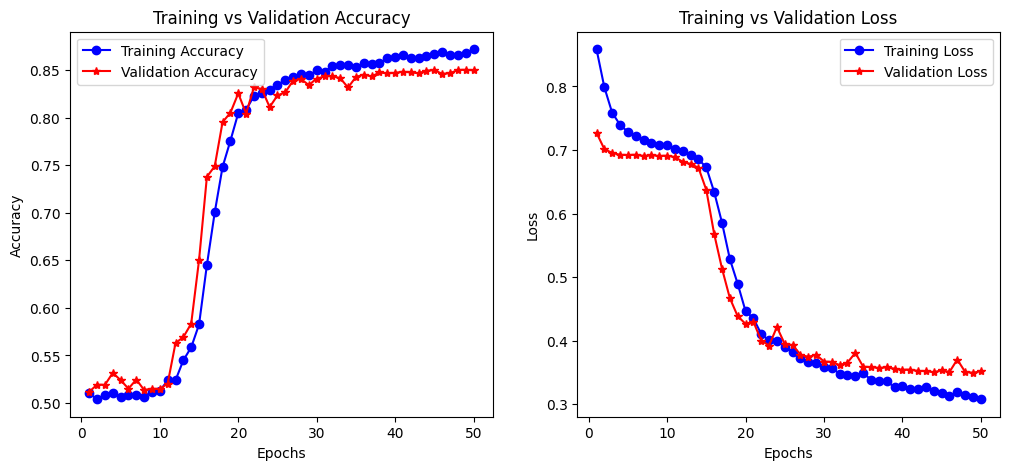

In [19]:
# -------------------- Plot Training and Validation Accuracy & Loss --------------------

# Set figure size for better readability (width=12, height=5)
plt.figure(figsize=(12, 5))

# -------------------- Accuracy Plot --------------------
plt.subplot(1, 2, 1)  # (1 row, 2 columns, plot 1 → left side)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')   # Blue line with circles
plt.plot(epochs, val_acc, 'r*-', label='Validation Accuracy')   # Red line with stars
plt.xlabel('Epochs')     # X-axis = number of epochs
plt.ylabel('Accuracy')   # Y-axis = accuracy
plt.title('Training vs Validation Accuracy')  # Graph title
plt.legend()             # Show legend (blue = training, red = validation)

# -------------------- Loss Plot --------------------
plt.subplot(1, 2, 2)  # (1 row, 2 columns, plot 2 → right side)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')   # Blue line with circles
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')   # Red line with stars
plt.xlabel('Epochs')     # X-axis = number of epochs
plt.ylabel('Loss')       # Y-axis = loss
plt.title('Training vs Validation Loss')  # Graph title
plt.legend()             # Show legend

# -------------------- Display Both Graphs --------------------
plt.show()


In [20]:
# -------------------- Model Evaluation --------------------

# Predict probabilities for test dataset
# model.predict(X_test) → gives probability values between 0 and 1
y_pred = model.predict(X_test)

# Convert probabilities into binary predictions (0 or 1)
# If probability > 0.5 → classify as Positive (1), else Negative (0)
y_pred = (y_pred > 0.5)

# -------------------- Confusion Matrix --------------------
# A 2x2 matrix showing classification results:
# [ [True Negatives, False Positives],
#   [False Negatives, True Positives] ]
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# -------------------- Classification Report --------------------
# Shows Precision, Recall, F1-score, and Support for each class
#   - Precision: % of predicted positives that are actually correct
#   - Recall: % of actual positives that were correctly predicted
#   - F1-score: harmonic mean of precision & recall
#   - Support: number of samples in each class
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)


157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step
Confusion Matrix:
[[2038  397]
 [ 351 2214]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      2435
           1       0.85      0.86      0.86      2565

    accuracy                           0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       0.85      0.85      0.85      5000



##  Training LSTM

In [24]:
# -------------------- Improved Sentiment Analysis Model --------------------

# Sequential model (stack of layers)
model = Sequential([

    # Embedding layer: Converts word indices into dense vectors
    # - input_dim = max_words (size of vocabulary)
    # - output_dim = 300 (embedding vector size → richer representation)
    # - input_length = max_sequence_length (ensures fixed input size)
    Embedding(input_dim=max_words, output_dim=300, input_length=max_sequence_length),

    # First Bidirectional LSTM layer
    # - 128 units → captures long-range dependencies
    # - return_sequences=True → passes full sequence to next layer
    # - recurrent_dropout=0.2 → drops recurrent connections for regularization
    Bidirectional(LSTM(128, return_sequences=True, recurrent_dropout=0.2)),

    # Normalization to stabilize and speed up training
    LayerNormalization(),

    # Dropout for regularization (prevents overfitting)
    Dropout(0.3),

    # Second Bidirectional LSTM layer
    # - returns final output only (since return_sequences=False by default)
    # - recurrent_dropout=0.2 → prevents memorization of training data
    Bidirectional(LSTM(128, recurrent_dropout=0.2)),

    # Normalize again
    LayerNormalization(),
    Dropout(0.3),

    # Fully connected Dense layer with ReLU
    Dense(64, activation="relu"),

    # Dropout for further regularization
    Dropout(0.2),

    # Output layer → sigmoid for binary classification (positive/negative)
    Dense(1, activation='sigmoid')
])

# -------------------- Compilation --------------------
# - Loss = binary_crossentropy (since it's binary classification)
# - Optimizer = Adam with a very small learning rate (5e-5) for stable training
# - Metric = Accuracy
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=5e-5),
              metrics=['accuracy'])

# -------------------- Early Stopping --------------------
# Stops training when validation loss does not improve for 5 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# -------------------- Training --------------------
# - Epochs = 50 (training iterations)
# - Batch size = 512 (process 512 samples at once)
# - Validation data = X_test, y_test (for model evaluation during training)
# - Verbose=1 → show progress bar
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=512,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 173s 4s/step - accuracy: 0.5369 - loss: 0.7556 - val_accuracy: 0.6424 - val_loss: 0.6443
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 213s 5s/step - accuracy: 0.6053 - loss: 0.6625 - val_accuracy: 0.6926 - val_loss: 0.5964
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 383s 10s/step - accuracy: 0.6791 - loss: 0.5949 - val_accuracy: 0.7572 - val_loss: 0.5109
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 134s 3s/step - accuracy: 0.7429 - loss: 0.5188 - val_accuracy: 0.7848 - val_loss: 0.4585
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - accuracy: 0.7855 - loss: 0.4613 - val_accuracy: 0.7998 - val_loss: 0.4295
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.8083 - loss: 0.4263 - val_accuracy: 0.8114 - val_loss: 0.4089
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.8207 - loss: 0.4036 - val_accuracy: 0.8286 - val_loss: 0.3891
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.8292 - loss: 0.3843 - val_accuracy: 0.8308 - 

## Model Evaluation

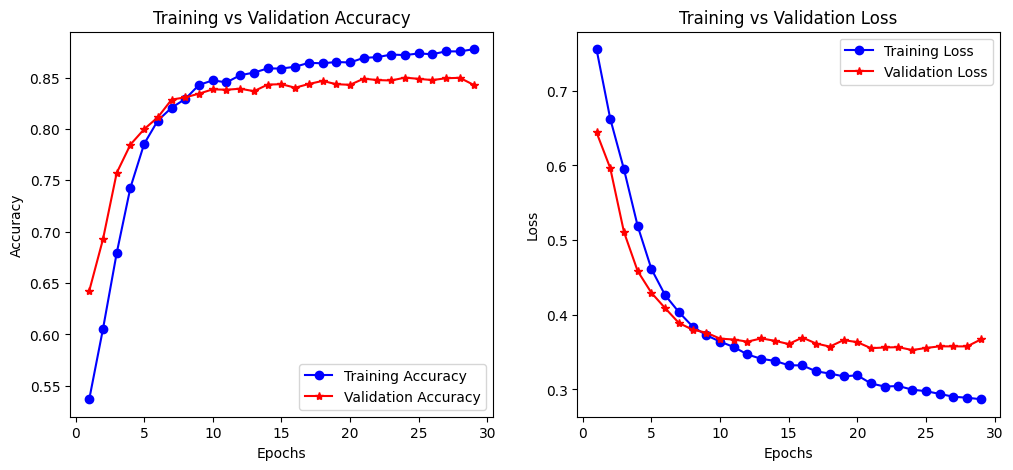

In [25]:
import matplotlib.pyplot as plt

# -------------------- Extract Training History --------------------
# "history.history" stores all metrics from training
# - 'accuracy' = training accuracy
# - 'val_accuracy' = validation accuracy
# - 'loss' = training loss
# - 'val_loss' = validation loss
epochs = range(1, len(history.history['accuracy']) + 1)  # X-axis → epoch numbers
train_acc = history.history['accuracy']                 # Training accuracy values
val_acc = history.history['val_accuracy']               # Validation accuracy values
train_loss = history.history['loss']                    # Training loss values
val_loss = history.history['val_loss']                  # Validation loss values

# -------------------- Plot Accuracy --------------------
plt.figure(figsize=(12, 5))  # Create a figure of size 12x5

# Left plot: Accuracy
plt.subplot(1, 2, 1)  # 1 row, 2 columns, position 1
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')  # Blue dots + line
plt.plot(epochs, val_acc, 'r*-', label='Validation Accuracy')  # Red stars + line
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# -------------------- Plot Loss --------------------
# Right plot: Loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, position 2
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')   # Blue dots + line
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')   # Red stars + line
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# -------------------- Show Plots --------------------
plt.show()


In [26]:
# -------------------- Model Evaluation --------------------

# Predict probabilities on the test set
# Output will be values between 0 and 1 (since last layer = sigmoid)
y_pred = model.predict(X_test)

# Convert probabilities into binary predictions (0 or 1)
# Threshold = 0.5 → if prob > 0.5 → Positive (1), else Negative (0)
y_pred = (y_pred > 0.5)

# -------------------- Confusion Matrix --------------------
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
# Format: [[TN, FP],
#          [FN, TP]]
# TN = True Negatives, FP = False Positives
# FN = False Negatives, TP = True Positives

# -------------------- Classification Report --------------------
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)
# Gives detailed metrics:
# - Precision: Correct positive predictions out of all predicted positives
# - Recall: Correct positive predictions out of all actual positives
# - F1-score: Balance between precision & recall
# - Support: Number of samples per class


157/157 ━━━━━━━━━━━━━━━━━━━━ 43s 267ms/step
Confusion Matrix:
[[2075  360]
 [ 390 2175]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.85      2435
           1       0.86      0.85      0.85      2565

    accuracy                           0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       0.85      0.85      0.85      5000



##  Training GRU

In [27]:
# -------------------- Define Improved GRU Model --------------------
model = Sequential([
    # Embedding layer: converts word indices into dense vectors of size 300
    # input_dim = max_words → size of vocabulary
    # output_dim = 300 → embedding dimension
    # input_length = max_sequence_length → each review has length 100 (padded)
    Embedding(input_dim=max_words, output_dim=300, input_length=max_sequence_length),  
    
    # First GRU Layer
    # - 128 units → number of neurons
    # - return_sequences=True → keeps sequence output for stacking another GRU
    # - dropout=0.3 → regular dropout (on input connections)
    # - recurrent_dropout=0.2 → dropout on recurrent connections (hidden state)
    GRU(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.2),
    
    # Normalization helps stabilize training and speed convergence
    LayerNormalization(),
    
    # Second GRU Layer
    # - 128 units
    # - This time return_sequences=False (default), so it outputs final hidden state
    GRU(128, dropout=0.3, recurrent_dropout=0.2),
    
    # Normalization again for better gradient flow
    LayerNormalization(),
    
    # Dropout layer to prevent overfitting
    Dropout(0.3),
    
    # Fully connected dense layer
    # - 64 neurons
    # - ReLU activation for non-linearity
    Dense(64, activation="relu"),
    
    # Another dropout layer
    Dropout(0.2),
    
    # Output layer: binary classification (positive vs negative)
    # Sigmoid gives probability between 0 and 1
    Dense(1, activation='sigmoid')
])

# -------------------- Compile the Model --------------------
# Loss: binary_crossentropy (since 2 classes)
# Optimizer: Adam with small learning rate (5e-5) for stable learning
# Metrics: accuracy (to track during training)
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=5e-5), metrics=['accuracy'])

# -------------------- Early Stopping --------------------
# Stops training if val_loss does not improve for 5 epochs
# Restores best weights to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# -------------------- Train the Model --------------------
history = model.fit(
    X_train, y_train,
    epochs=50,                 # max epochs
    batch_size=512,            # large batch for efficiency
    validation_data=(X_test, y_test),  # evaluate on test set during training
    callbacks=[early_stopping],        # apply early stopping
    verbose=1
)

# -------------------- Extract Training History --------------------
# These lists will be used for plotting accuracy/loss curves
epochs = range(1, len(history.history['accuracy']) + 1)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']


Epoch 1/50


C:\Users\dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.5257 - loss: 0.8058 - val_accuracy: 0.5960 - val_loss: 0.6735
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.5554 - loss: 0.7436 - val_accuracy: 0.6224 - val_loss: 0.6432
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.5747 - loss: 0.7082 - val_accuracy: 0.6418 - val_loss: 0.6257
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.5975 - loss: 0.6813 - val_accuracy: 0.6540 - val_loss: 0.6128
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.6175 - loss: 0.6606 - val_accuracy: 0.6712 - val_loss: 0.5971
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.6333 - loss: 0.6429 - val_accuracy: 0.6842 - val_loss: 0.5833
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.6511 - loss: 0.6247 - val_accuracy: 0.6992 - val_loss: 0.5691
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.6688 - loss: 0.6115 - val_accuracy: 0.7082 - val_loss: 0.5571
Epo

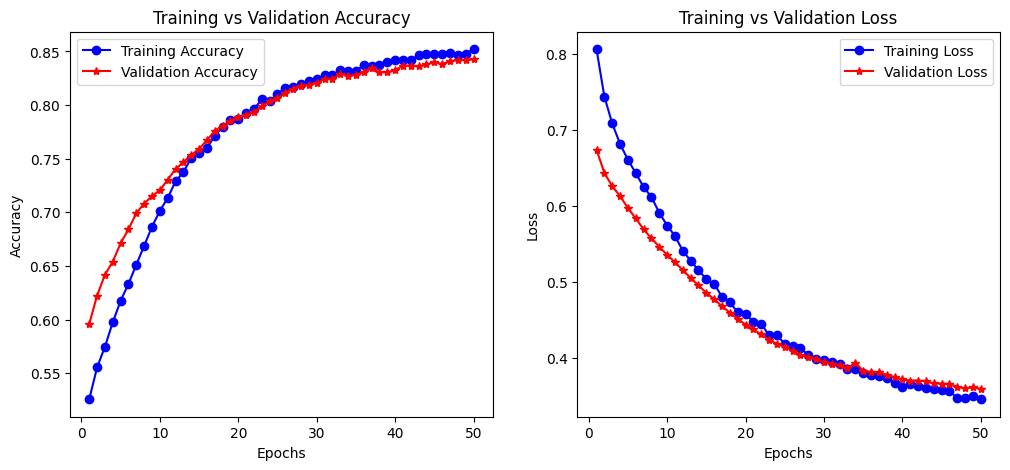

In [28]:
# -------------------- Plot Training vs Validation Performance --------------------
plt.figure(figsize=(12, 5))  # Set figure size

# ---------- Accuracy Plot ----------
plt.subplot(1, 2, 1)  # Left plot (1 row, 2 cols, first plot)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')   # Blue circles for training accuracy
plt.plot(epochs, val_acc, 'r*-', label='Validation Accuracy')   # Red stars for validation accuracy
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# ---------- Loss Plot ----------
plt.subplot(1, 2, 2)  # Right plot (1 row, 2 cols, second plot)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')   # Blue circles for training loss
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')   # Red stars for validation loss
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Show plots
plt.show()


##  Detection System

In [29]:
# -------------------- Model Evaluation --------------------

# Predict probabilities on the test set
# Since final layer = sigmoid, predictions are values between 0 and 1
y_pred = model.predict(X_test)

# Convert probabilities into binary predictions (0 or 1)
# Threshold = 0.5 → if prob > 0.5 → Positive (1), else Negative (0)
y_pred = (y_pred > 0.5)

# -------------------- Confusion Matrix --------------------
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
# Example output: [[2200  300]
#                  [ 250 2250]]
# Format:
#   [[TN, FP],
#    [FN, TP]]
# TN = True Negatives → correctly predicted negatives
# FP = False Positives → predicted positive but actually negative
# FN = False Negatives → predicted negative but actually positive
# TP = True Positives → correctly predicted positives

# -------------------- Classification Report --------------------
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)
# Provides detailed metrics for each class:
# - Precision: Correct positive predictions / all predicted positives
# - Recall: Correct positive predictions / all actual positives
# - F1-score: Harmonic mean of Precision & Recall (balance)
# - Support: Number of samples in each class


157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 97ms/step
Confusion Matrix:
[[2035  400]
 [ 386 2179]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      2435
           1       0.84      0.85      0.85      2565

    accuracy                           0.84      5000
   macro avg       0.84      0.84      0.84      5000
weighted avg       0.84      0.84      0.84      5000



In [30]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# -------------------- Function to Predict Sentiment --------------------
def predict_sentiment(text, model, tokenizer, max_sequence_length=100):
    """
    Takes raw text input and predicts sentiment using the trained model.
    
    Args:
        text (str): Input review or sentence.
        model: Trained Keras model (RNN/LSTM/GRU).
        tokenizer: Fitted Keras tokenizer.
        max_sequence_length (int): Length to pad/truncate input sequence.
    
    Returns:
        sentiment (str): "Positive 😊" or "Negative 😡"
        prediction (float): Probability score (0-1)
    """

    # Step 1: Clean the text (lowercase, remove stopwords, stemming)
    text = clean_text(text)
    
    # Step 2: Convert cleaned text into sequence of word indices
    sequence = tokenizer.texts_to_sequences([text])
    
    # Step 3: Pad the sequence to the same length as model input
    padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length)
    
    # Step 4: Predict probability using the trained model
    # model.predict returns array [[probability]], so extract scalar
    prediction = model.predict(padded_sequence)[0][0]
    
    # Step 5: Convert probability to sentiment label
    sentiment = "Positive 😊" if prediction > 0.5 else "Negative 😡"
    
    return sentiment, float(prediction)

# -------------------- Example Usage --------------------
test_sentences = [
    "I love this product! It's amazing.",  # clearly positive
    "This is the worst service I have ever experienced.",  # clearly negative
    "The movie was okay, not great but not terrible either."  # neutral/ambiguous
]

# Predict sentiment for each sentence
for sentence in test_sentences:
    sentiment, confidence = predict_sentiment(sentence, model, tokenizer)
    print(f"Text: {sentence}")
    print(f"Predicted Sentiment: {sentiment} (Confidence: {confidence:.4f})\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Text: I love this product! It's amazing.
Predicted Sentiment: Positive 😊 (Confidence: 0.9966)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Text: This is the worst service I have ever experienced.
Predicted Sentiment: Negative 😡 (Confidence: 0.0044)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Text: The movie was okay, not great but not terrible either.
Predicted Sentiment: Negative 😡 (Confidence: 0.0824)



In [31]:
# -------------------- Save Trained Model --------------------
# model.save("lstm_model.h5") saves:
# 1. Model architecture (layers, configuration)
# 2. Weights (trained parameters)
# 3. Optimizer state (so you can resume training if needed)
# File format: HDF5 (.h5)
model.save("lstm_model.h5")

# -------------------- Save Tokenizer --------------------
# Tokenizer contains word-to-index mapping and other preprocessing info
# Necessary for converting new text to sequences the model understands
import pickle

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
